# Setup

In [195]:
import warnings
warnings.simplefilter("ignore")

In [196]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.10.1
  import geopandas as gpd

if gpd.__version__ != "0.10.1":
  !pip install -U geopandas==0.10.1
  import geopandas as gpd

In [197]:
try:
  import rasterio as rio
except ModuleNotFoundError as e:
  !pip install rasterio==1.2.3
  import rasterio as rio

if rio.__version__ != "1.2.3":
  !pip install -U rasterio==1.2.3
  import rasterio as rio

In [198]:
try:
  import owslib
except ModuleNotFoundError as e:
  !pip install owslib==0.25.0
  import owslib

if owslib.__version__ != "0.25.0":
  !pip install -U owslib==0.25.0
  import owslib

In [199]:
from matplotlib import pyplot as plt

# Exercises
- clip the area with the shape of Polo Ferrari (in front on FBK)
- create the altitude profile of the street "Via Sommarive"
- find the area FBK in the WMS of municipality of Trento - layer "Carta Tecnica 1:2.000 alta risoluzione" and vectorize it
- identify the shortest path from the pizzeria Oro Stube until the main entrance of FBK over the DTM
---


## clip the area with the shape of Polo Ferrari (in front on FBK)
1. identify the area of Polo Ferrari
2. download the raster of scientific hub in Povo
3. clip area

In [200]:
import geopandas as gpd
import rasterio 
from rasterio.mask import mask
from rasterio.plot import show

### 1. identify the area of Polo Ferrari

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/polo_ferrari_overpassturbo.png)

[http://overpass-turbo.eu/s/ZzP](http://overpass-turbo.eu/s/ZzP
)

[geojson](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/polo_ferrari_boundary.geojson)



In [201]:
geojson_polo_ferarri = "https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/polo_ferrari_boundary.geojson"

In [202]:
polo_ferrari = gpd.read_file(geojson_polo_ferarri)

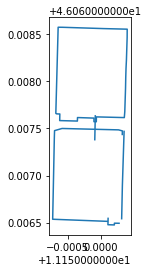

In [203]:
polo_ferrari.plot()
plt.show()

In [204]:
polo_ferrari.geometry.type.unique()

array(['LineString'], dtype=object)

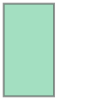

In [205]:
polo_ferrari.geometry.unary_union.envelope

In [206]:
area_polo_ferrari = polo_ferrari.geometry.unary_union.envelope

In [207]:
type(area_polo_ferrari)

shapely.geometry.polygon.Polygon

### 2. download the raster of scientific hub in Povo


In [208]:
url_download_orthophoto_scientific_hub_povo = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo.tif'

In [209]:
raster = rasterio.open(url_download_orthophoto_scientific_hub_povo)

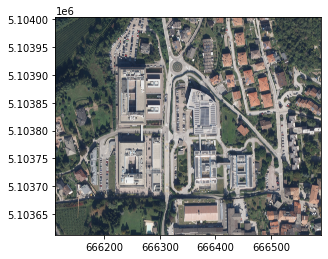

<AxesSubplot:>

In [210]:
show(raster)

In [211]:
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4761,
 'height': 3900,
 'count': 3,
 'crs': CRS.from_epsg(25832),
 'transform': Affine(0.09999999999999999, 0.0, 666113.0,
        0.0, -0.09999999999999999, 5104003.0)}

### 3. clip area

In [212]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [213]:
gdf_polo_ferrari_25832 = gpd.GeoSeries([area_polo_ferrari]).set_crs("EPSG:4326").to_crs("EPSG:25832")

In [214]:
coords = getFeatures(gdf_polo_ferrari_25832)

In [215]:
coords

[{'type': 'Polygon',
  'coordinates': [[[666221.9300357221, 5103679.093307299],
    [666310.1180686228, 5103681.477369573],
    [666303.8138183788, 5103914.6097356975],
    [666215.6291314249, 5103912.225679764],
    [666221.9300357221, 5103679.093307299]]]}]

In [216]:
raster_polo_ferrari, raster_polo_ferrari_transform = mask(raster, coords, crop=True)

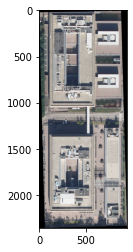

<AxesSubplot:>

In [217]:
show(raster_polo_ferrari)

In [218]:
raster_polo_ferrari_meta = raster.meta

In [219]:
raster_polo_ferrari_meta.update({"driver": "GTiff",
                 "height": raster_polo_ferrari.shape[1],
                 "width": raster_polo_ferrari.shape[2],
                 "transform": raster_polo_ferrari_transform})

with rasterio.open("polo_ferrari_orthophoto.tif", "w", **raster_polo_ferrari_meta) as dest:
    dest.write(raster_polo_ferrari)

In [220]:
#uncomment if you want download with colab
#from google.colab import files
#files.download('polo_ferrari_orthophoto.tif')

## create the altitude profile of the street “Via Sommarive”
1. download the street "Via Sommarive" from OpenStreetMap
1. download the DTM file of the scientific hub of Povo
1. clip the street inside the area covered of the DTM
1. extract the points of the street
1. extract the altitude value for each points
1. show the altitude
---


### 1. download the street "Via Sommarive" from OpenStreetMap

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/via_sommarive_overpassturbo.png)

[](http://overpass-turbo.eu/s/ZA0)

[geojson](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/via_sommarive.geojson)

In [221]:
via_sommarive = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/via_sommarive.geojson")

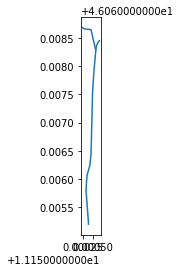

In [222]:
via_sommarive.plot()
plt.show()

### 2. download the DTM file of the scientific hub of Povo

In [223]:
import urllib.request
url_download_dtm_scientific_hub_povo = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.asc'
dtm = "trento_scientifc_hub_povo_dtm.asc"
urllib.request.urlretrieve(url_download_dtm_scientific_hub_povo ,dtm) 
url_download_dtm_scientific_hub_povo_prj = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.prj'
dtm_prj = "trento_scientifc_hub_povo_dtm.prj"
urllib.request.urlretrieve(url_download_dtm_scientific_hub_povo_prj ,dtm_prj) 

('trento_scientifc_hub_povo_dtm.prj',
 <http.client.HTTPMessage at 0x7fa2f786dc10>)

In [224]:
dtm = "trento_scientifc_hub_povo_dtm.asc"

In [225]:
raster_dtm = rasterio.open(dtm)

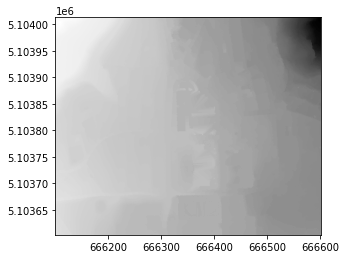

<AxesSubplot:>

In [226]:
show(raster_dtm, cmap='Greys')

### 3. clip the street inside the area covered of the DTM

In [227]:
raster_dtm.bounds

BoundingBox(left=666100.6735466761, bottom=5103603.23583161, right=666600.6735466761, top=5104013.23583161)

In [228]:
minx = raster_dtm.bounds.left
maxx = raster_dtm.bounds.right
miny = raster_dtm.bounds.bottom
maxy = raster_dtm.bounds.top


![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/boudingbox.png)

In [229]:
from shapely.geometry import Polygon

In [230]:
bbox_raster_dtm = Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])

In [231]:
geoseries_bbox_raster_dtm = gpd.GeoSeries([bbox_raster_dtm]).set_crs("EPSG:25832").to_crs("EPSG:4326")

In [232]:
geoseries_bbox_raster_dtm

0    POLYGON ((11.14767 46.06582, 11.15413 46.06570...
dtype: geometry

In [233]:
gdf_bbox_raster_dtm = gpd.GeoDataFrame(geometry=geoseries_bbox_raster_dtm)

In [234]:
gdf_bbox_raster_dtm

,geometry
0,"POLYGON ((11.14767 46.06582, 11.15413 46.06570..."


In [235]:
sommarive_street_inside_dtm = gpd.overlay(via_sommarive, gdf_bbox_raster_dtm, how='intersection')

In [236]:
sommarive_street_inside_dtm

,id,@id,highway,lit,maxspeed:type,name,surface,maxspeed,source:maxspeed,geometry
0,way/97004470,way/97004470,unclassified,yes,IT:urban,Via Sommarive,asphalt,None,None,"LINESTRING (11.15033 46.06577, 11.15033 46.065..."
1,way/382958545,way/382958545,residential,None,None,Via Sommarive,asphalt,50,sign,"LINESTRING (11.15058 46.06828, 11.15045 46.068..."


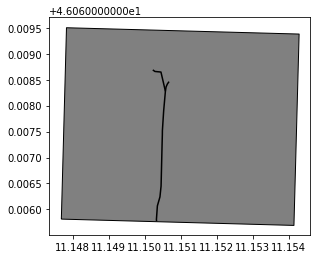

In [237]:
fig, ax = plt.subplots()
sommarive_street_inside_dtm.plot(ax=ax, color='black', edgecolor='black')
gdf_bbox_raster_dtm.plot(ax=ax, color='gray', edgecolor='black')
plt.show();

In [238]:
sommarive_street_inside_dtm.highway

0    unclassified
1     residential
Name: highway, dtype: object

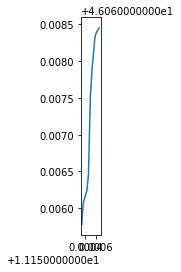

In [239]:
sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].plot()
plt.show()

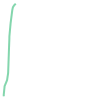

In [240]:
sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].geometry.values[0]

In [241]:
linestring_sommarive_street = sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].geometry.values[0]

### 4. extract the points of the street
we need to convert the points from WGS84 to ETRS89

In [242]:
import shapely
import pyproj
from shapely.ops import transform

In [243]:
wgs84 = pyproj.CRS('EPSG:4326')
crs_dtm = pyproj.CRS('EPSG:25832')
projection_transform = pyproj.Transformer.from_crs(wgs84, crs_dtm, always_xy=False).transform

In [244]:
def convert(x,y):
  p = shapely.geometry.Point(y,x)
  p = transform(projection_transform,p)
  return(p)

In [245]:
pointsx = []
pointsy = []
for coordinate in linestring_sommarive_street.coords:
  x = coordinate[0]
  y = coordinate[1]
  point = convert(x,y)
  pointsx.append(point.x)
  pointsy.append(point.y)

In [246]:
pointsx[0]

666306.4552006973

In [247]:
pointsy[0]

5103603.23091181

### 4. extract the altitude value for each points

In [248]:
import pandas as pd

In [249]:
#calculate the distance point-to-point
from shapely.geometry import Point,LineString
lengths = []
previousPoint = None
length = 0
for i in range(len(pointsx)):
  point = shapely.geometry.Point(pointsy[i],pointsx[i])
  if previousPoint is None:
    lengths.append(length)
  else:
    length = LineString([previousPoint,point]).length + length
    lengths.append(length)  
  previousPoint = point 


In [250]:
lengths

[0,
 3.951209709379636,
 32.831459096031196,
 52.98060861208776,
 76.0895772860392,
 92.85559295912803,
 165.21088895179275,
 186.20305604231848,
 194.89525293084407,
 237.7301320929318,
 279.66422694854015,
 288.77768975533206,
 295.6826859435214,
 301.98476544998357]

In [251]:
raster_dtm.count

1

In [252]:
data = raster_dtm.read(1)

In [253]:
data

array([[335., 335., 335., ..., 468., 469., 469.],
       [334., 334., 334., ..., 469., 469., 469.],
       [334., 334., 334., ..., 469., 469., 469.],
       ...,
       [357., 357., 357., ..., 400., 400., 401.],
       [356., 357., 357., ..., 400., 400., 400.],
       [356., 357., 357., ..., 400., 400., 400.]], dtype=float32)

In [254]:
rows,cols = rasterio.transform.rowcol(raster_dtm.transform,(pointsx),(pointsy))

In [255]:
values = []
for i in range(len(rows)):
  values.append(data[rows[i]-1][cols[i]-1]) 

In [256]:
values

[382.0,
 382.0,
 380.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 380.0,
 380.0,
 381.0,
 381.0]

In [257]:
sommarive_street_3d = pd.DataFrame()

In [258]:
sommarive_street_3d['value'] = values

In [259]:
sommarive_street_3d['length'] = lengths

In [260]:
sommarive_street_3d

,value,length
0,382.0,0.000000
1,382.0,3.951210
2,380.0,32.831459
3,378.0,52.980609
4,378.0,76.089577
5,378.0,92.855593
6,378.0,165.210889
7,378.0,186.203056
8,378.0,194.895253
9,378.0,237.730132


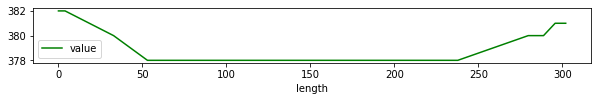

In [261]:
ax = sommarive_street_3d.plot(y='value',x="length",color='green',figsize=(10,1))
plt.show()

## find the area FBK in the WMS of municipality of Trento - layer “Carta Tecnica 1:2.000 alta risoluzione” and vectorize it

1. create a bounding box based on the FBK area in Povo
1. load the WMS of muncipality of Trento as rasterio on the size of the bounding box
1. vectorize the rasterio
---


### 1. create a bounding box based on the FBK area in Povo
.. we can use the same geojson extracted from OSM used on the lesson

In [262]:
fbk = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/boundary_fbk_povo.geojson")

In [263]:
bbox = fbk.geometry[0].bounds

In [264]:
bbox

(11.1505197, 46.0664359, 11.1530713, 46.0684635)

In [265]:
fbk.shape

(1, 10)

### 2. load the WMS of muncipality of Trento as rasterio on the size of the bounding box

In [266]:
from owslib.wms import WebMapService
import rasterio.crs

In [267]:
wms_trento = "http://webapps.comune.trento.it/ogc"
wms = WebMapService(wms_trento)

In [268]:
title="Carta Tecnica 1:2.000 alta risoluzione a colori"

In [269]:
for content in wms.contents:
  layer = wms[content]
  if layer.title == title:
    break

In [270]:
content

'ct2000_colori'

In [271]:
layer.crsOptions

['EPSG:4326', 'EPSG:3857', 'EPSG:25832']

In [272]:
request = wms.getmap(
    layers=[content],
    srs='EPSG:4326',
    format='image/tiff',
    bbox=bbox,
    size=(1024,800)
    )

In [273]:
from rasterio import MemoryFile
from rasterio.plot import show
from rasterio import features

In [274]:
wms_image = MemoryFile(request).open()

In [275]:
wms_image.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1024, 'height': 800, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(2.4917968750015575e-06, 0.0, 11.1505197,
       0.0, -2.5344999999997646e-06, 46.0684635), 'tiled': False, 'interleave': 'pixel'}

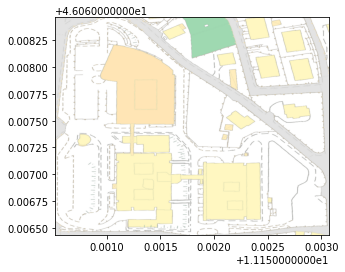

<AxesSubplot:>

In [276]:
show(wms_image)

In [277]:
wms_image.count

3

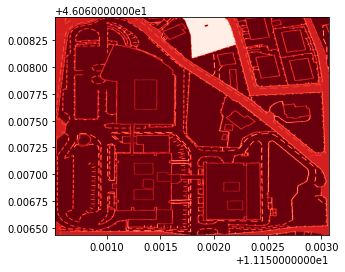

<AxesSubplot:>

In [278]:
show((wms_image, 1), cmap='Reds')

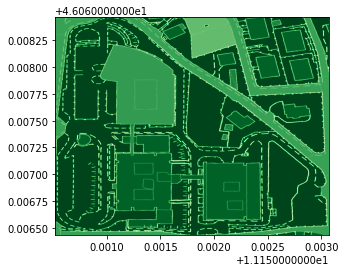

<AxesSubplot:>

In [279]:
show((wms_image, 2), cmap='Greens')

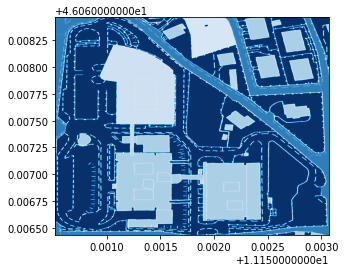

<AxesSubplot:>

In [280]:
show((wms_image, 3), cmap='Blues')

In [281]:
from rasterio.features import shapes
image = wms_image.read(3) # first band
mask = image != 255
results = (
  {'properties': {'raster_val': v}, 'geometry': s}
  for i, (s, v) 
    in enumerate(
      shapes(image, mask=mask, transform=wms_image.transform)))

In [282]:
geoms = list(results)

In [283]:
fbk_area_vector  = gpd.GeoDataFrame.from_features(geoms)

In [284]:
fbk_area_vector.shape

(78339, 2)

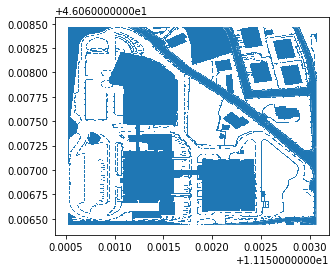

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [285]:
fbk_area_vector.plot()
plt.show()
%time

FBK Buildings

- [North](https://www.openstreetmap.org/?mlat=46.06782&mlon=11.15156#map=19/46.06782/11.15156)
- [West](https://www.openstreetmap.org/?mlat=46.06689&mlon=11.15116#map=19/46.06689/11.15116)
- [East](https://www.openstreetmap.org/?mlat=46.06684&mlon=11.15200#map=19/46.06684/11.15200)

In [286]:
p_north = shapely.geometry.Point(11.15156,46.06782)

In [287]:
building_north = fbk_area_vector[fbk_area_vector.geometry.contains(p_north)]

In [288]:
building_north

,geometry,raster_val
42228,"POLYGON ((11.15107 46.06820, 11.15107 46.06820...",181.0


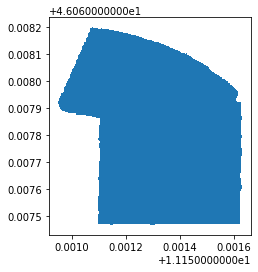

In [289]:
building_north.plot()
plt.show()

In [290]:
p_west = shapely.geometry.Point(11.15116,46.06689)
building_west = fbk_area_vector[fbk_area_vector.geometry.contains(p_west)]

In [291]:
p_east = shapely.geometry.Point(11.15200,46.06684)
building_east = fbk_area_vector[fbk_area_vector.geometry.contains(p_east)]

In [292]:
building_east

,geometry,raster_val
70295,"POLYGON ((11.15198 46.06710, 11.15198 46.06710...",193.0


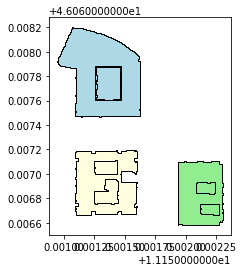

In [293]:
fig, ax = plt.subplots()
building_north.plot(ax=ax, color='lightblue', edgecolor='black')
building_west.plot(ax=ax, color='lightyellow', edgecolor='black')
building_east.plot(ax=ax, color='lightgreen', edgecolor='black')
plt.show();

## identify the shortest path from the pizzeria Oro Stube until the main entrance of FBK over the DTM

for this operation we will use:
- [xarray-spatial](https://xarray-spatial.org/)<Br/>
xarray-spatial is a package for raster-based spatial analytics<br/>
among the supported functions is the implementation of the algorithm [A*](https://en.wikipedia.org/wiki/A*_search_algorithm)<Br/>
A* is an informed search algorithm, or a best-first search, meaning that it is formulated in terms of weighted graphs: starting from a specific starting node of a graph, it aims to find a path to the given goal node having the smallest cost (min distance travelled, shortest time, …).
- [rioxarray](https://github.com/corteva/rioxarray)<Br/>
the geospatial xarray extension powered by rasterio 



In [294]:
try:
  import xrspatial 
except ModuleNotFoundError as e:
  !pip install xarray-spatial==0.2.9
  import xrspatial 

if xrspatial.__version__ != "0.2.9":
  !pip install -U xarray-spatial==0.2.9
  import xrspatial

In [295]:
try:
  import rioxarray 
except ModuleNotFoundError as e:
  !pip install rioxarray==0.5.0
  import rioxarray 

if rioxarray.__version__ != "0.5.0":
  !pip install -U rioxarray==0.5.0
  import rioxarray

In [296]:
try:
    import geopy
except ModuleNotFoundError as e:
    !pip install geopy==2.2.0
    import geopy
if geopy.__version__ != "2.2.0":
    !pip install -U geopy==2.2.0
    import geopy

In [297]:
import numpy as np
import pandas as pd
import rioxarray
import datashader as ds
from xrspatial import a_star_search
from geopy.geocoders import Nominatim 

The <span style="color:blue">xrspatial.a_star_search</span> function calculate the shortest path in pixel space from a start location to a goal location through a given aggregate surface graph.<br/><Br/>The graph should be a **line raster** which contains crossable and non-crossable (a.k.a walls or barrieres) values.<br/><Br/>
**Note** that both start and goal are in (lon, lat), or (x, y) coordinate space and *must be within the graph*.<br/><br/>The <span style="color:blue">xrspatial.a_star_search</span> provides 2 separate options, **snap_start** and **snap_goal**, which can be set true to snap *locations to the nearest valid value* before beginning pathfinding.<br/><br/>
It also provides connectivity option to indicate neighborhood structure.<br/><br/>
This value can be set to either *4* or *8* that represents for *4-connectivity* and *8-connectivity* accordingly.

### identify the two starting points

In [298]:
geolocator = Nominatim(user_agent="Example for the course")

In [299]:
pizzeria = geolocator.geocode("Pizzeria OroStube")
fbk = geolocator.geocode("Via Sommarive 18, Trento, Italy")

In [300]:
point_pizzeria = convert(pizzeria.longitude,pizzeria.latitude)
point_fbk = convert(fbk.longitude,fbk.latitude)

### check if the points are inside the area covered from the DTM

In [301]:
bbox_raster_dtm.contains(point_fbk)

True

In [302]:
bbox_raster_dtm = gdf_bbox_raster_dtm.to_crs(epsg=25832).geometry[0]

In [303]:
bbox_raster_dtm.contains(point_pizzeria)

False

In [304]:
round(bbox_raster_dtm.distance(point_pizzeria),3)

112.332

the pizzeria is outside the DTM<br/>
We need to find a point on the DTM closest to the pizzeria OroStube

In [305]:
# transform the DTM in a DataFrame
dtm_rioxarray = rioxarray.open_rasterio(dtm)
grid_df = dtm_rioxarray.to_dataframe("z").reset_index()

In [306]:
# Transform the DTM in a GeoDataFrame
grid_points= gpd.GeoDataFrame(
    grid_df,
    crs='EPSG:25832',
    geometry=gpd.points_from_xy(grid_df.x, grid_df.y))

In [307]:
min_distance = round(min(grid_points.geometry.distance(point_pizzeria)),3)
point_closest_pizzeria = grid_points[round(grid_points.geometry.distance(point_pizzeria),3) ==min_distance ]

In [308]:
point_closest_pizzeria = point_closest_pizzeria.geometry.values[0]

In [309]:
point_closest_pizzeria.distance(point_pizzeria)

112.833215057246

In [310]:
start_pizzeria_orostube = (round(point_closest_pizzeria.x,3), round(point_closest_pizzeria.y,3))

In [311]:
# define range of x and y
xrange = (grid_df['x'].min(), grid_df['x'].max())
yrange = (grid_df['y'].min(), grid_df['y'].max())
W = dtm_rioxarray.x.size
H = dtm_rioxarray.y.size
#An abstract canvas representing the space in which to bin.
ds_canvas = ds.Canvas(plot_width=W, plot_height=H,
                x_range=xrange, y_range=yrange)
# Compute a reduction by pixel, mapping data to pixels as one or more lines
grid_agg = ds_canvas.line(grid_df, x='x', y='y').astype(int)
goal_fbk = (point_fbk.x, point_fbk.y)


In [312]:
grid_agg

<xarray.DataArray (y: 410, x: 500)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
  * x        (x) float64 6.661e+05 6.661e+05 6.661e+05 ... 6.666e+05 6.666e+05
  * y        (y) float64 5.104e+06 5.104e+06 5.104e+06 ... 5.104e+06 5.104e+06

In [313]:
location_df = pd.DataFrame({'x': [start_pizzeria_orostube[0], goal_fbk[0]], 'y': [start_pizzeria_orostube[1], goal_fbk[1]]})

In [314]:
# find the path from start to goal,
# barriers are uncrossable cells. In this case, they are cells with a value of 0
# in our case there aren't barries 
path_agg_8_connectivity = a_star_search(grid_agg, start_pizzeria_orostube, goal_fbk, barriers=[0], snap_start=True, snap_goal=True)

In [315]:
# extract the path created in a dataframe
df_path = path_agg_8_connectivity.to_dataframe("z").reset_index()
df_path = df_path[~df_path.z.isnull()]

In [316]:
# create the geodataframe
geo_path = gpd.GeoDataFrame(
    df_path,
    crs='EPSG:25832',
    geometry=gpd.points_from_xy(df_path.x, df_path.y))

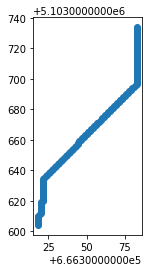

In [317]:
geo_path.plot()
plt.show()

In [318]:
geo_path.explore()

The image clearly shows that the surface does not take into account buildings and other perimeters where it is not possible to move.<br/>It is therefore advisable to revise the DTM by assigning a value of 0 to the non-walkable areas.

In [319]:
sommarive_street_inside_dtm.to_crs(25832)

,id,@id,highway,lit,maxspeed:type,name,surface,maxspeed,source:maxspeed,geometry
0,way/97004470,way/97004470,unclassified,yes,IT:urban,Via Sommarive,asphalt,None,None,"LINESTRING (666306.455 5103603.231, 666306.052..."
1,way/382958545,way/382958545,residential,None,None,Via Sommarive,asphalt,50,sign,"LINESTRING (666317.905 5103882.035, 666307.229..."


In [320]:
request = wms.getmap(
    layers=[content],
    srs='EPSG:25832',
    format='image/tiff',
    bbox=bbox_raster_dtm.bounds,
    size=(W,H)
    )

In [321]:
wms_image_over_dtm = MemoryFile(request).open()

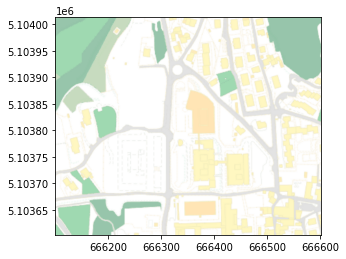

<AxesSubplot:>

In [322]:
show(wms_image_over_dtm)

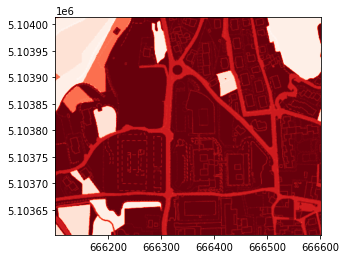

<AxesSubplot:>

In [323]:
show((wms_image_over_dtm, 1), cmap='Reds')

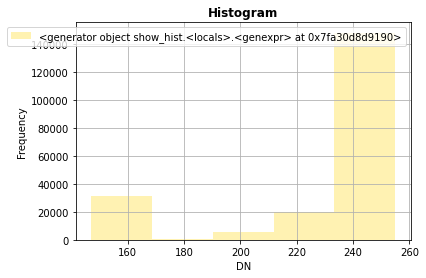

In [324]:
from rasterio.plot import show_hist
show_hist(wms_image_over_dtm.read(1), bins=5, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [331]:
from rasterio.features import shapes
image = wms_image_over_dtm.read(1) # first band
mask = np.ma.masked_inside(image,186,227).mask
results = (
  {'properties': {'raster_val': v}, 'geometry': s}
  for i, (s, v) 
    in enumerate(
      shapes(image, mask=mask, transform=wms_image.transform)))

In [332]:
geoms = list(results)

In [333]:
dtm_area_vector  = gpd.GeoDataFrame.from_features(geoms)

In [334]:
dtm_area_vector.head(3)

,geometry,raster_val
0,"POLYGON ((11.15054 46.06846, 11.15054 46.06846...",221.0
1,"POLYGON ((11.15054 46.06846, 11.15054 46.06846...",222.0
2,"POLYGON ((11.15054 46.06846, 11.15054 46.06846...",211.0


In [335]:
dtm_area_vector = dtm_area_vector.set_crs(4326)

In [336]:
dtm_area_vector.to_crs(25832,inplace=True)

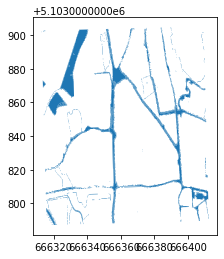

In [337]:
dtm_area_vector.plot()
plt.show()

In [396]:
import json
dtm_area_vector_json = json.loads(dtm_area_vector.to_json())
coords_for_clipping = []
for feature in dtm_area_vector_json['features']:
    coords_for_clipping.append(feature['geometry'])

In [399]:
from rasterio.mask import mask
out_img, out_transform = mask(raster_dtm, coords_for_clipping, crop=True)

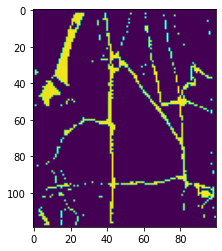

<AxesSubplot:>

In [400]:
show(out_img)

In [401]:
out_meta = raster_dtm.meta

In [402]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform})

with rio.open("clipper_dtm.tif", "w", **out_meta) as dest:
    dest.write(out_img)


In [410]:
# transform the DTM in a DataFrame
dtm_clipped_rioxarray = rioxarray.open_rasterio("clipper_dtm.tif")
grid_clipped_df = dtm_clipped_rioxarray.to_dataframe("z").reset_index()

In [415]:
# define range of x and y
xrange_clipped = (grid_clipped_df['x'].min(), grid_df['x'].max())
yrange_clipped = (grid_clipped_df['y'].min(), grid_df['y'].max())
Wc = dtm_clipped_rioxarray.x.size
Hc = dtm_clipped_rioxarray.y.size
#An abstract canvas representing the space in which to bin.
ds_canvas_clipped = ds.Canvas(plot_width=Wc, plot_height=Hc,
                x_range=xrange_clipped, y_range=yrange_clipped)
# Compute a reduction by pixel, mapping data to pixels as one or more lines
grid_clipped_agg = ds_canvas_clipped.line(grid_clipped_df, x='x', y='y').astype(int)

In [417]:
# Transform the DTM in a GeoDataFrame
grid_points_clipped= gpd.GeoDataFrame(
    grid_clipped_df,
    crs='EPSG:25832',
    geometry=gpd.points_from_xy(grid_clipped_df.x, grid_clipped_df.y))

In [451]:
min_distance_pizzeria = round(min(grid_points_clipped.geometry.distance(point_pizzeria)),3)
point_closest_pizzeria_clipped = grid_points_clipped[round(grid_points_clipped.geometry.distance(point_pizzeria),3) ==min_distance_pizzeria ]

In [455]:
min_distance_pizzeria

188.028

In [452]:
point_closest_pizzeria_clipped

,band,y,x,spatial_ref,z,geometry
22751,1,5.103679e+06,666310.173547,0,0.0,POINT (666310.174 5103678.736)


In [443]:
point_closest_pizzeria_clipped = point_closest_pizzeria_clipped.geometry.values[0]

In [453]:
min_distance_fbk = round(min(grid_points_clipped.geometry.distance(point_fbk)),3)
point_closest_fbk_clipped = grid_points_clipped[round(grid_points_clipped.geometry.distance(point_fbk),3) ==min_distance_fbk]

In [456]:
min_distance_fbk

73.162

In [454]:
point_closest_fbk_clipped

,band,y,x,spatial_ref,z,geometry
17471,1,5.103734e+06,666310.173547,0,0.0,POINT (666310.174 5103733.736)


In [444]:
point_closest_fbk_clipped = point_closest_fbk_clipped.geometry.values[0]

In [445]:
start_pizzeria_orostube_clipped = (round(point_closest_pizzeria_clipped.x,3), round(point_closest_pizzeria_clipped.y,3))

In [446]:
goal_fbk_clipped = (round(point_closest_fbk_clipped.x,3), round(point_closest_fbk_clipped.y,3))

In [447]:
path_clipped = a_star_search(grid_clipped_agg, start_pizzeria_orostube_clipped, goal_fbk_clipped, barriers=[0], snap_start=True, snap_goal=True)

In [448]:
# extract the path created in a dataframe
df_path_clipped = path_clipped.to_dataframe("z").reset_index()
df_path_clipped = df_path_clipped[~df_path_clipped.z.isnull()]

In [449]:
# create the geodataframe
geo_path_clipped = gpd.GeoDataFrame(
    df_path_clipped,
    crs='EPSG:25832',
    geometry=gpd.points_from_xy(df_path_clipped.x, df_path_clipped.y))

In [450]:
geo_path_clipped.explore()